In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
from pystan import StanModel 
from numpy import polyval, place, extract, any, asarray, nan, inf, pi
from numpy import (where, arange, putmask, ravel, sum, shape,
                   log, sqrt, exp, arctanh, tan, sin, arcsin, arctan,
                   tanh, cos, cosh, sinh, log1p, expm1)

from scipy.stats import rv_continuous
from scipy.stats import f
from prettytable import PrettyTable
import datetime
import os # to save file to a selected directories, which do not need to be created

class frechet_gen(rv_continuous):
#     def _argcheck(self, c):
#         c = asarray(c)
#         self.b = where(c < 0, 1.0/abs(c), inf)
#         return where(c == 0, 0, 1)

#     def _pdf(self, x, alpha1, alpha2, beta):
#         Px = 1 / beta / ss.beta(alpha1, alpha2) * pow(x/beta, asarray(alpha1-1.0)) * pow(1 + x/beta, asarray(- alpha1 - alpha2))
#         return Px

#     def _logpdf(self, x, alpha1, alpha2, beta):
#         return (alpha1 - 1) * np.log(x) - alpha1 * np.log(beta) - np.log(ss.beta(alpha1, alpha2)) - (alpha1 + alpha2) * np.log(1 + x/beta)

    def _cdf(self, x, beta):
        return exp(-pow(x, -1/beta))
#     def _ppf(self, q, c):
#         vals = 1.0/c * (pow(1-q, -c)-1)
#         return vals

#     def _munp(self, n, c):
#         k = arange(0, n+1)
#         val = (-1.0/c)**n * sum(comb(n, k)*(-1)**k / (1.0-c*k), axis=0)
#         return where(c*n < 1, val, inf)

#     def _entropy(self, c):
#         if (c > 0):
#             return 1+c
#         else:
#             self.b = -1.0 / c
#             return rv_continuous._entropy(self, c)
frechet = frechet_gen(a=0.0, name='frechet') # we specify the support [a,b], no b means b = infinity

In [3]:
GPD = """
functions {
  real myGPD_lpdf(real y, real alpha, real beta) {
      return -(alpha + 1)*( log(1+y/beta) )+(log(alpha) - log(beta));
  }
  real myBetaPrior_lpdf(real x, real beta) {
      return -log(beta); // log(1/beta) = log(1) - log(beta) = - log(beta)
  }
}
data { 
  int N;
  real y[N]; // points sampled from gpd in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  real alpha;
  real beta;
}
model {
  // Priors; no priors - we assume improper priors on params
  alpha ~ gamma(1,1);
  beta ~ gamma(1,1);

// Likelihood
  for(n in 1:N) {
    target += myGPD_lpdf( y[n] | alpha, beta );
  }
}
generated quantities{}
"""

Fisher = """
functions { 
 real myFisher_lpdf(real y, real alpha1, real alpha2, real beta) {
      return -lbeta(alpha1,alpha2)-log(beta)+(alpha1-1)*log(y/beta)-(alpha1+alpha2)*log(1+y/beta);
  }
}
data { 
  int N;
  real y[N]; 
}
parameters { 
  //parameters of the Fisher
  real<lower=0> alpha1;
  real<lower=0> alpha2;
  real<lower=0> beta; 
}
model {
  // when we deliberately do not specify priors then Stan works with improper priors
  alpha1 ~ gamma(1,1);
  alpha2 ~ gamma(1,1);
  beta ~ gamma(1,1);
   // Likelihood
  for(n in 1:N) {
    target += myFisher_lpdf( y[n] |alpha1, alpha2, beta);
  }
}
generated quantities{}
"""

In [62]:
q = [0.98, 0.99, 0.995, 0.999, 0.9995]
beta = 1/2
quant_th = np.zeros(len(q))
for i in range(len(q)):
    quant_th[i] = pow(-log(q[i]), -beta)

def quantiles_GPD(excesses, k, u): 
    """ 
    we forward to function array of the quantiles as excesses, the number of excesses, k, and the border value u
    """
    quant_GPD = np.zeros(len(q)) 
    bayesian_quant_GPD = np.zeros(len(q))

    # here we fit GPD to excesses via PyStan
    data = dict(N = k,  y = excesses) 
    fit = StanModel(model_code=GPD).sampling(data=data,iter=1000,warmup=200, chains=1) 
    
    # we save the params from the fit to calculate GPD quantiles and their traceplots to calculate Bayesian GPD quantiles
    traceplot_beta_GPD = list(fit.extract().values())[1].tolist() 
    traceplot_alpha = list(fit.extract().values())[0].tolist()
    traceplot_gamma = np.divide(np.ones(len(traceplot_alpha)), traceplot_alpha)
    beta_GPD = np.mean(list(fit.extract().values())[1].tolist())
    alpha = np.mean(list(fit.extract().values())[0].tolist())
    gamma = 1 / alpha 
    
    for i in range(len(q)):
        quant_GPD[i] = u + beta_GPD*( pow( N * (1-q[i]) / k, -gamma ) - 1 ) 
        for j in range(len(traceplot_gamma)):
                bayesian_quant_GPD[i] += u + traceplot_beta_GPD[j] * (pow( N * (1 - q[i]) / k, - traceplot_gamma[j] ) - 1)
    bayesian_quant_GPD = bayesian_quant_GPD / len(traceplot_gamma)
    list_of_params = [alpha, beta_GPD]
    return(quant_GPD, bayesian_quant_GPD, list_of_params ) # it return arrays: quant_GPD, bayesian_quant_GPD and values alpha, beta_GPD

def quantiles_Fisher(excesses, k, u):
    quant_Fisher = np.zeros(len(q)) 
    bayesian_quant_Fisher = np.zeros(len(q))
    
    # here we fit GPD to excesses via PyStan
    data = dict(N = k,  y = excesses) 
    fit = StanModel(model_code=Fisher).sampling(data=data,iter=1000,warmup=200, chains=1) 
    
    # we save the params from the fit to calculate Fisher quantiles and their traceplots to calculate Bayesian Fisher quantiles
    traceplot_beta = list(fit.extract().values())[2].tolist()
    traceplot_alpha1 = list(fit.extract().values())[0].tolist()
    traceplot_alpha2 = list(fit.extract().values())[1].tolist()
    beta = np.mean(list(fit.extract().values())[2].tolist())
    alpha2 = np.mean(list(fit.extract().values())[1].tolist())
    alpha1 = np.mean(list(fit.extract().values())[0].tolist())
    beta0 = alpha2/alpha1
    
    for i in range(len(q)):
        quant_Fisher[i] = u + beta0 / beta * f.isf(N / k * (1-q[i]), 2 * alpha1, 2 * alpha2, loc=0, scale=1)
        for j in range(len(traceplot_alpha1)):
                bayesian_quant_Fisher[i] += u + traceplot_alpha2[j] / traceplot_alpha1[j] / traceplot_beta[j] * f.isf(N / k *(1- q[i]), 2 * traceplot_alpha1[j], 2 * traceplot_alpha2[j], loc=0, scale=1)
    bayesian_quant_Fisher = bayesian_quant_Fisher / len(traceplot_alpha1)
    list_of_params = [alpha1, alpha2, beta]
    return(quant_Fisher, bayesian_quant_Fisher, list_of_params) 
# it return arrays: quant_Fisher, bayesian_quant_Fisher and values of params as a list


In [60]:
def plot_table(k, averaged_bayesian_quant_Fisher, 
               averaged_quant_Fisher, 
               averaged_bayesian_quant_GPD, 
               averaged_quant_GPD, now, repetitions, nb_thresholds):
    m = "3" # how much we round
    rounding = "%." + m + "f"
    m = int(m)
    t_quantiles = PrettyTable(["# of excesses k = " +  str(k),  
                               'mean', 
                               'sd',
                               str(q[0] * 100) + "%", 
                               str(q[1] * 100) + "%",
                               str(q[2] * 100) + "%",
                               str(q[3] * 100) + "%",
                               str(q[4] * 100) + "%"])
    t_quantiles.add_row(['theoretically', '--', '--',
                         rounding % round(quant_th[0],m),  
                         rounding % round(quant_th[1], m), 
                         rounding % round(quant_th[2], m),
                         rounding % round(quant_th[3], m),
                         rounding % round(quant_th[4], m) ])
    t_quantiles.add_row(['Bayes Fisher',  '--', '--',
                         rounding % round(averaged_bayesian_quant_Fisher[0],m),  
                         rounding % round(averaged_bayesian_quant_Fisher[1], m), 
                         rounding % round(averaged_bayesian_quant_Fisher[2], m),
                         rounding % round(averaged_bayesian_quant_Fisher[3], m),
                         rounding % round(averaged_bayesian_quant_Fisher[4], m) ])
    t_quantiles.add_row(['Fisher',  '--', '--',
                         rounding % round(averaged_quant_Fisher[0],m),  
                         rounding % round(averaged_quant_Fisher[1], m), 
                         rounding % round(averaged_quant_Fisher[2], m),
                         rounding % round(averaged_quant_Fisher[3], m),
                         rounding % round(averaged_quant_Fisher[4], m) ])
    t_quantiles.add_row(['Bayes GPD', '--', '--',
                         rounding % round(averaged_bayesian_quant_GPD[0],m),  
                         rounding % round(averaged_bayesian_quant_GPD[1], m), 
                         rounding % round(averaged_bayesian_quant_GPD[2], m),
                         rounding % round(averaged_bayesian_quant_GPD[3], m),
                         rounding % round(averaged_bayesian_quant_GPD[4], m) ])
    t_quantiles.add_row(['GPD',  '--', '--',
                         rounding % round(averaged_quant_GPD[0],m),  
                         rounding % round(averaged_quant_GPD[1], m), 
                         rounding % round(averaged_quant_GPD[2], m),
                         rounding % round(averaged_quant_GPD[3], m),
                         rounding % round(averaged_quant_GPD[4], m) ])
    data = t_quantiles.get_string()
    # ---------------
    dir_name = str(now.day) + "_" + str(now.month) + "_" + str(now.year) + "_at_" + str(now.hour) + "_" + str(now.minute)
#     name = " quant_level_" + str(q[quantile_level])
    script_dir = os.path.dirname('__file__')
    results_dir = os.path.join(script_dir, dir_name + '/')
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)

#  results_dir +   "repetitions_" + str(repetitions) + "_nb_thresholds_" + str(nb_thresholds) 
    with open(results_dir +   "repetitions_" + str(repetitions) + "_nb_thresholds_" + str(nb_thresholds) + '.txt', 'w') as f:
        f.write(data)
    # ---------------
    return(print(t_quantiles))

def compare_quantiles(jump_excesses, GPD, BGPD, Fisher, BFisher, theoretical_quantile,  quantile_level, now):
    plt.hlines(y=theoretical_quantile[quantile_level], 
               xmin=min(jump_excesses), 
               xmax=max(jump_excesses), 
               color='yellow', 
               zorder=1, 
               label='theoretical value')
    dir_name = str(now.day) + "_" + str(now.month) + "_" + str(now.year) + " at " + str(now.hour) + ":" + str(now.minute)
    name = " quant level: " + str(q[quantile_level])
    #------
    dir_name = str(now.day) + "_" + str(now.month) + "_" + str(now.year) + "_at_" + str(now.hour) + "_" + str(now.minute)
    name = " quant_level_" + str(q[quantile_level])
    script_dir = os.path.dirname('__file__')
    results_dir = os.path.join(script_dir, dir_name + '/')
    sample_file_name = name + '.pdf'
    fig = plt.figure()
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
    ax = fig.add_subplot(111)
    ax.plot(jump_excesses)
    fig.savefig(results_dir + sample_file_name )  
    #------
    plt.plot(jump_excesses, GPD[quantile_level,:],  'r', label='GPD') # plotting t, a separately 
    plt.plot(jump_excesses, BGPD[quantile_level,:], 'b', label='BGPD') # plotting t, b separately 
    plt.plot(jump_excesses, Fisher[quantile_level,:], 'g', label='Fisher') # plotting t, c separately 
    plt.plot(jump_excesses, BFisher[quantile_level,:], 'm', label='BFisher') # plotting t, c separately 

    plt.xlabel('number of excesses')
    plt.ylabel('value of quantile at level ' + str(q[quantile_level]))
    plt.title('Variability of quantile at level ' + str(q[quantile_level])  )
    plt.legend()
    plt.savefig(results_dir + sample_file_name)
    return(plt.show())

def k_greatest_values_matrices(a,k):
    """returns k greatest elements from the list a and k - 1 value starting from which we consider greater values as extremes"""
    # we prepare the matrix for the excesses, the last value of 1 could be substituted by any value within the range
    mat = np.zeros( len(a[-1 - k + 1 : , 1] ) ) 
    # we prepare the vector in which we will return u values for each dataset in column of a
    u = np.zeros(len(r[0 , : ] )) 
    for i in range(len(a[0,:])): 
        # index i goes through the columns, instead of len(a[0,:]) there could be len(a[i,:]) for i in range of columns
        u[i] = a[-1 - k, i] 
        # u is a list of values s.t. bigger values are considered as excesses, for each set of data, i.e. for each column we save an u value
        mat = np.column_stack( (mat,a[ -1 - k + 1 : , i]) ) 
    # in mat matrix we return the values of excesses but not yet transformed (y_i = x_i - u)
    return(mat, u) # u is the starting value from which we consider others as excesses

In [6]:
n = 1 # number of sampled dataset over which we average the quantiles
N, beta = 1000,  1/2

r = frechet.rvs(beta, size=N)
for i in range(n):
    r = np.column_stack( (r, frechet.rvs(beta, size=N) ) ) 

# we need to sort in increasing order sampled data
for i in range(len(r[0,:])):
    r[:,i] = np.sort(r[:,i], axis=None)

In [61]:
how_many_different_thresholds = 1
min_thresholds = 50
max_thresholds = N / 2
# astype function converts the values in the array to integers
jump_excesses = np.linspace(min_thresholds, max_thresholds, how_many_different_thresholds).astype(int) 

number_of_GPD_params = 2
number_of_Fisher_params = 3

averaged_params_GPD, averaged_params_Fisher =  np.zeros(number_of_GPD_params), np.zeros(number_of_Fisher_params)


# we initialize the matrices of quantiles with row of zeros
concatenated_averaged_quant_GPD, concatenated_averaged_bayesian_quant_GPD = np.zeros(len(q)), np.zeros(len(q))
concatenated_averaged_quant_Fisher, concatenated_averaged_bayesian_quant_Fisher = np.zeros(len(q)), np.zeros(len(q))

# counter = 0 # counter to normalize over the values of parameters

for j in range(len(jump_excesses)): # for different threshold of excesses
    k = jump_excesses[j]
    
    # in data frechet we keep the matrix of excesses
    # transferred r is a matrix with n sampled dataset from Frechet
    
    data_frechet, u = k_greatest_values_matrices(r,k) 

    # delete first column (indexed by 0) of a matrix A, to match the sizes 
    A = np.delete(data_frechet, 0, 1)

    # form the array of u values we create matrix, in columns we have repeated u values   
    B = [ [x] * k for x in u ] 

    # here we subtract u_i from excesses in each dataset
    C = np.array(A) - np.array(B).transpose() 
#     counter = counter +  1
    averaged_quant_GPD, averaged_bayesian_quant_GPD = np.zeros(len(q)), np.zeros(len(q))
    averaged_quant_Fisher, averaged_bayesian_quant_Fisher = np.zeros(len(q)), np.zeros(len(q))

    for i in range(n): 
#         counter = counter +  1

        # we fit GPD and Fisher distributions to excesses from each dataset
        excesses_array = C[:,i] # asarray(C.transpose().tolist()[i]) 
        quant_GPD, bayesian_quant_GPD, params_GPD = quantiles_GPD(excesses_array, k, u[i])
        quant_Fisher, bayesian_quant_Fisher, params_Fisher = quantiles_Fisher(excesses_array, k, u[i])
#         print("\n quant_Fisher : \n ", quant_Fisher,"\n bayesian_quant_Fisher: \n", bayesian_quant_Fisher)
        averaged_quant_GPD += quant_GPD
        averaged_bayesian_quant_GPD += bayesian_quant_GPD
        averaged_params_GPD += params_GPD 
#         print("\n averaged_quant_GPD \n ", averaged_quant_GPD, "\n averaged_bayesian_quant_GPD \n", averaged_bayesian_quant_GPD)
        
        averaged_quant_Fisher += quant_Fisher
#         print("\n averaged_quant_Fisher: \n", averaged_quant_Fisher)
        averaged_bayesian_quant_Fisher += bayesian_quant_Fisher
#         print("\n averaged_bayesian_quant_Fisher: \n", averaged_bayesian_quant_Fisher)
        averaged_params_Fisher += params_Fisher 

        
#     print("\n counter: \n", counter)    
    averaged_quant_GPD = averaged_quant_GPD / n 
    averaged_bayesian_quant_GPD = averaged_bayesian_quant_GPD / n
    averaged_params_GPD = asarray(averaged_params_GPD) / n

    averaged_quant_Fisher = averaged_quant_Fisher / n 
    averaged_bayesian_quant_Fisher = averaged_bayesian_quant_Fisher / n
    averaged_params_Fisher = asarray(averaged_params_Fisher) / n
    
#     print("quant_Fisher \n ",averaged_quant_Fisher, "bayesian_quant_Fisher \n ", averaged_bayesian_quant_Fisher )
    
    now = datetime.datetime.now()

    plot_table(jump_excesses[j], 
           averaged_bayesian_quant_Fisher, 
           averaged_quant_Fisher, 
           averaged_bayesian_quant_GPD, 
           averaged_quant_GPD,
           now, n, how_many_different_thresholds)
    
#     print(" Current number of excesses k = " + str(jump_excesses[j]), 
#           "\n", "averaged_params_GPD: ", averaged_params_GPD, 
#           "\n", "averaged_params_Fisher: ", averaged_params_Fisher)
    
    #preparing to plot
    
    concatenated_averaged_quant_GPD = np.column_stack( (concatenated_averaged_quant_GPD, averaged_quant_GPD ) )
    concatenated_averaged_bayesian_quant_GPD = np.column_stack( (concatenated_averaged_bayesian_quant_GPD, averaged_bayesian_quant_GPD ) )
    concatenated_averaged_quant_Fisher = np.column_stack( (concatenated_averaged_quant_Fisher, averaged_quant_Fisher ) )
    concatenated_averaged_bayesian_quant_Fisher = np.column_stack( (concatenated_averaged_bayesian_quant_Fisher, averaged_bayesian_quant_Fisher ) )

# we delete first column which was created as zeros
concatenated_averaged_quant_GPD = np.delete(concatenated_averaged_quant_GPD, 0, 1)
concatenated_averaged_bayesian_quant_GPD = np.delete(concatenated_averaged_bayesian_quant_GPD, 0, 1)
concatenated_averaged_quant_Fisher = np.delete(concatenated_averaged_quant_Fisher, 0, 1)
concatenated_averaged_bayesian_quant_Fisher = np.delete(concatenated_averaged_bayesian_quant_Fisher, 0, 1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.
C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.


+----------------------+------+----+-------+-------+--------+--------+--------+
| # of excesses k = 50 | mean | sd | 98.0% | 99.0% | 99.5%  | 99.9%  | 99.95% |
+----------------------+------+----+-------+-------+--------+--------+--------+
|    theoretically     |  --  | -- | 7.036 | 9.975 | 14.124 | 31.615 | 44.716 |
|     Bayes Fisher     |  --  | -- | 5.542 | 6.582 | 8.204  | 16.794 | 24.877 |
|        Fisher        |  --  | -- | 5.337 | 6.070 | 7.157  | 12.224 | 16.368 |
|      Bayes GPD       |  --  | -- | 6.965 | 9.918 | 14.712 | 43.378 | 74.609 |
|         GPD          |  --  | -- | 6.915 | 9.604 | 13.573 | 31.672 | 46.158 |
+----------------------+------+----+-------+-------+--------+--------+--------+


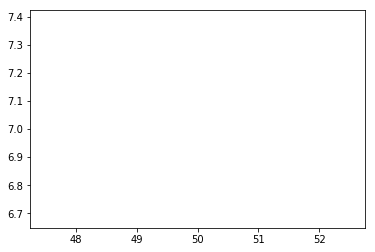

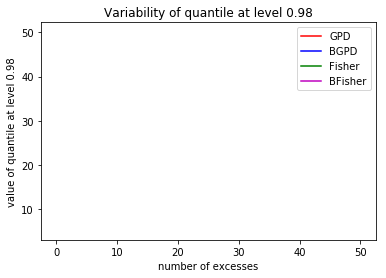

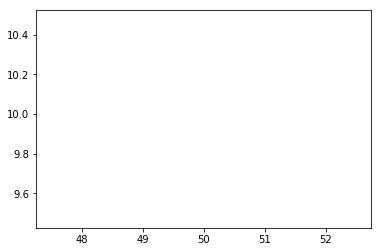

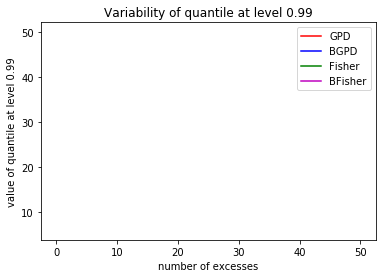

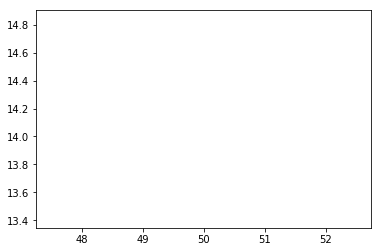

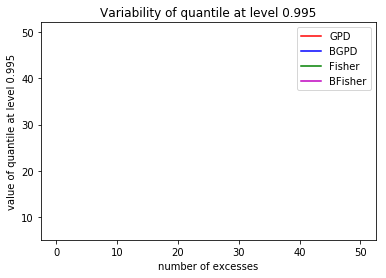

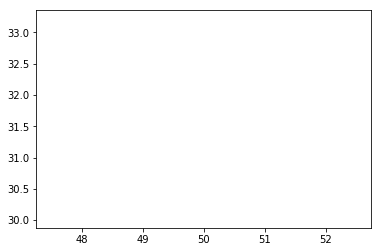

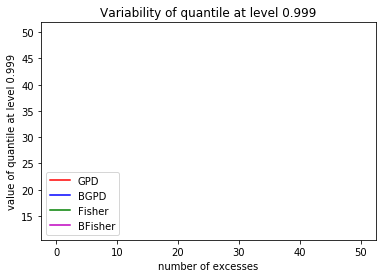

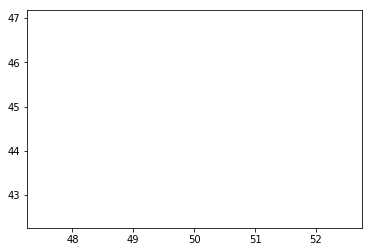

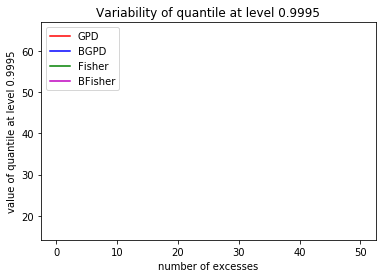

In [45]:
# fig.savefig('graph.png')
for i in range(len(q)):
    now = datetime.datetime.now()

    compare_quantiles(jump_excesses,
                  concatenated_averaged_quant_GPD, 
                  concatenated_averaged_bayesian_quant_GPD, 
                  concatenated_averaged_quant_Fisher, 
                      concatenated_averaged_bayesian_quant_Fisher,
                  quant_th,
                  i,
                  now)

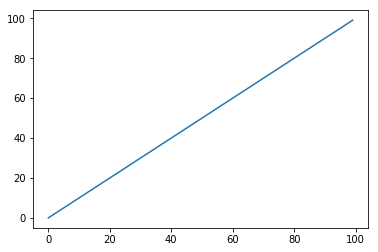

In [41]:
now = datetime.datetime.now()
dir_name = str(now.day) + "_" + str(now.month) + "_" + str(now.year) + "_at_" + str(now.hour) + "_" + str(now.minute)
name = " quant_level_" + str(q[1])
    #------
script_dir = os.path.dirname('__file__')
results_dir = os.path.join(script_dir, dir_name + '/')
sample_file_name = name + '.pdf'
print(sample_file_name)

fig = plt.figure()

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
ax = fig.add_subplot(111)
ax.plot(range(100))

# fig.savefig("PyStan_recovers_good_values_of_Fischer.pdf", bbox_inches='tight')
fig.savefig(results_dir + sample_file_name )